This notebook continues from EDA Feature Engineering. 
The experiments were carried out on a fraction of the sample data because of the computational requirements. 

Most of this Notebook was prepared with Google Colab. The URLs to file locations on Google Drive can be replaced by the local file path. i.e. /content/drive/MyDrive/output/train_complete.csv should be substituted with ../output/train_complete.csv

Please note that some files were considered too large for Git and are not available.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import packages and saved files and folders


train_df = pd.read_csv('/content/drive/MyDrive/output/train_complete.csv')
test_df = pd.read_csv('/content/drive/MyDrive/output/test_complete.csv')

preprocessed_train_q1 = pd.read_csv('/content/drive/MyDrive/output/preprocessed_train_1.csv',
                                    header=None).fillna("")
preprocessed_train_q2 = pd.read_csv('/content/drive/MyDrive/output/preprocessed_train_2.csv',
                                    header=None).fillna("")
preprocessed_test_q1 = pd.read_csv('/content/drive/MyDrive/output/preprocessed_test_1.csv',
                                   header=None).fillna("")
preprocessed_test_q2 = pd.read_csv('/content/drive/MyDrive/output/preprocessed_test_2.csv',
                                   header=None).fillna("")


**Note**: With Deep Learning with Tensorflow/Keras, I found the option to convert the data into a streamable format. I could not find anything similar with SKLearn's machine learning models. Therefore, I have to work on a fraction (0.2) of the available dataset. This has to be selected based on class size as the classese (`'is_duplicate'` 1 or 0) are out of balance.

In [4]:
y_train = train_df['is_duplicate']
display(y_train.value_counts())
unbalanced_ratio = y_train.value_counts()[0]/y_train.value_counts()[1]

0    204006
1    119424
Name: is_duplicate, dtype: int64

In [5]:

filter = y_train == 1

train_df_sample_1 = train_df[filter].sample(frac=0.05)
train_df_sample_0 = train_df[~filter].sample(frac=0.05/(unbalanced_ratio))
train_df__ = pd.concat([train_df_sample_1, train_df_sample_0])
train_df__['is_duplicate'].value_counts()

1    5971
0    5971
Name: is_duplicate, dtype: int64

In [6]:
# similar scaling down of the test_df
y_test = test_df['is_duplicate']
display(y_test.value_counts())
unbalanced_ratio = y_test.value_counts()[0]/y_test.value_counts()[1]

filter = y_test == 1

test_df_sample_1 = test_df[filter].sample(frac=0.1)
test_df_sample_0 = test_df[~filter].sample(frac=0.1/(unbalanced_ratio))
test_df__ = pd.concat([test_df_sample_1, test_df_sample_0])
test_df__['is_duplicate'].value_counts()

0    51018
1    29839
Name: is_duplicate, dtype: int64

1    2984
0    2984
Name: is_duplicate, dtype: int64

In [7]:
preprocessed_train_q1 = preprocessed_train_q1.iloc[train_df__.index].copy()
preprocessed_train_q2 = preprocessed_train_q2.iloc[train_df__.index].copy()
preprocessed_test_q1 = preprocessed_test_q1.iloc[test_df__.index].copy()
preprocessed_test_q2 = preprocessed_test_q2.iloc[test_df__.index].copy()


In [8]:
train_df = train_df__.copy()
test_df = test_df__.copy()

# Baseline Model

Our strategy is to prepare a baseline model with simple `LogisticRegression()`. Word vectorization will be done with `CountVectorizer()` and `TfidVectorizer()` until we observe a marked improvement with one of them.

## Word vectorization

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vec = CountVectorizer(min_df=2, max_features=5000)
tfid_vec = TfidfVectorizer(min_df=2, max_features=5000)



In [10]:
# converting the list of lists into a list of sentences that can be passed into the vectorizers
preprocessed_train_q1 = preprocessed_train_q1.applymap(str)
sentences_train_q1 = [' '.join(ele) for ele in preprocessed_train_q1.values]

preprocessed_train_q2 = preprocessed_train_q2.applymap(str)
sentences_train_q2 = [' '.join(ele) for ele in preprocessed_train_q2.values]


In [11]:
# doing the same for the text preprocessed text

preprocessed_test_q1 = preprocessed_test_q1.applymap(str)
sentences_test_q1 = [' '.join(ele) for ele in preprocessed_test_q1.values]

preprocessed_test_q2 = preprocessed_test_q2.applymap(str)
sentences_test_q2 = [' '.join(ele) for ele in preprocessed_test_q2.values]

In [12]:
count_X1 = count_vec.fit_transform(sentences_train_q1)
count_X2 = count_vec.fit_transform(sentences_train_q2)
count_X_q1_q2 = np.concatenate([count_X1.toarray(), count_X2.toarray()], axis=1)
count_X_q1_q2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
tdf_X1 = tfid_vec.fit_transform(sentences_train_q1)
tdf_X2 = tfid_vec.fit_transform(sentences_train_q2)
tdf_X_q1_q2 = np.concatenate([tdf_X1.toarray(), tdf_X2.toarray()], axis=1)
tdf_X_q1_q2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
### Evaluating model performance with CountVectorizer() transformation

In [88]:
# Preparing the training dataset
X = train_df.drop(columns=['question1', 'question2', 'is_duplicate'])
y = train_df['is_duplicate']
# concatenating with the vectorized text
X = pd.concat([X.reset_index(drop=True), pd.DataFrame(count_X_q1_q2)], axis=1, ignore_index=True)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [16]:
len(X)

11942

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=88)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10747, 9538), (1195, 9538), (10747,), (1195,))

In [53]:
# instantite and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

0.6379454731552991

0.6410041841004184

              precision    recall  f1-score   support

           0       0.83      0.60      0.70       817
           1       0.46      0.73      0.56       378

    accuracy                           0.64      1195
   macro avg       0.64      0.66      0.63      1195
weighted avg       0.71      0.64      0.65      1195



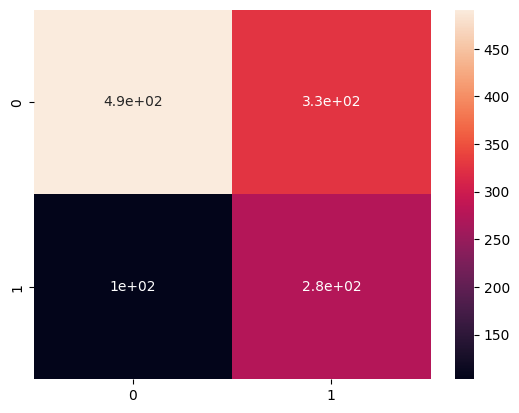

In [54]:
# get base scores
base_train_accuracy = model.score(X_train, y_train)
base_test_accuracy = model.score(X_test, y_test)

display(base_train_accuracy, base_test_accuracy)

y_pred = model.predict(X_test)
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
print(classification_report(y_pred, y_test))
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)



# visualize performance
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_pred, y_test)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
plt.show()

# saving the performance in a dictionary
count_vectorizer_base_performance = {
    'accuracy':accuracy,
    'precision':precision,
    'recall':recall,
    'fscore': fscore,
    'cf_matrix': cf_matrix,
    'classification_report': classification_report}

# GridSearch for best classifier with `CountVectorizer()`


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [34]:
clf1 = RandomForestClassifier(random_state=88)
# clf2 = SVC(probability=True, random_state=88)
clf3 = LogisticRegression(random_state=88)
clf4 = GradientBoostingClassifier(random_state=88)
clf5 = KNeighborsClassifier()
clf6 = BernoulliNB()
clf7 = XGBClassifier(random_state=88)

In [26]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__max_depth'] = [5]
param1['classifier'] = [clf1]

# param2 = {}
# param2['classifier'] = [clf2]

param3 = {}
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__n_estimators'] = [10, 50]
param4['classifier__max_depth'] = [5]
param4['classifier'] = [clf4]

param5 = {}
param5['classifier'] = [clf5]

param6 = {}
param6['classifier'] = [clf6]


param7 = {}
param7['classifier'] = [clf7]

# set up the pipeline and parameter grid
pipeline = Pipeline([('classifier', clf1)])

**Note**: Unfortunately the GridSearch could not run through all the parameter grid, even on Google Colab. I had to reduce the number of params passed through the grid to varying results. 

In [ ]:
params = [param4, param7]
gs = GridSearchCV(pipeline, params, cv=3, 
                  n_jobs=-1).fit(X_train, y_train)

In [30]:
display(gs.score(X_test, y_test))

0.8234309623430962

In [37]:
gs.score(X_train, y_train)

0.8791290592723551

In [38]:
params = [param5, param3]
gs2 = GridSearchCV(pipeline, params, cv=3, 
                  n_jobs=-1).fit(X_train, y_train)

display(gs2.score(X_test, y_test))
gs2.score(X_test, y_test)

0.6410041841004184

0.6410041841004184

In [ ]:
gs2.score(X_train, y_train)

In [35]:
params = [param1, param6]
gs3 = GridSearchCV(pipeline, params, cv=3, 
                  n_jobs=-1).fit(X_train, y_train)

display(gs3.score(X_test, y_test))

0.7171548117154811

In [36]:
gs3.score(X_train, y_train)

0.7379733879222109

In [41]:
# gs clearly gives the best performance
gs.best_params_

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=88, ...)}

Because of the circumstances of the experiment, we cannot conclusively say that no other classifier with the right set of parametrs woudl give a better performance.

## Performance Evaluation

In [40]:
y_pred = gs.predict(X_test)
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
print(classification_report(y_pred, y_test))
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       573
           1       0.84      0.81      0.83       622

    accuracy                           0.82      1195
   macro avg       0.82      0.82      0.82      1195
weighted avg       0.82      0.82      0.82      1195



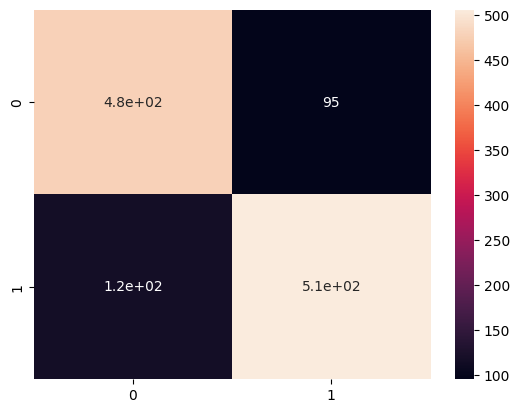

In [42]:
# visualize performance
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_pred, y_test)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
plt.show()

# saving the performance in a dictionary
count_vectorizer_performance = {
    'accuracy':accuracy,
    'precision':precision,
    'recall':recall,
    'fscore': fscore,
    'cf_matrix': cf_matrix,
    'classification_report': classification_report}

# GridSearch for best classifier with `TfiDVectorizer()`


In [69]:
# Preparing the training dataset with the tdidvectorized data
X = train_df.drop(columns=['question1', 'question2', 'is_duplicate'])
y = train_df['is_duplicate']
# concatenating with the vectorized text
X = pd.concat([X.reset_index(drop=True), pd.DataFrame(tdf_X_q1_q2)], axis=1, ignore_index=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=88)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10747, 9538), (1195, 9538), (10747,), (1195,))

In [45]:
# instantite and train the base model and get scores
model_tfd = LogisticRegression()
model_tfd.fit(X_train, y_train)

base_train_accuracy_tfd = model_tfd.score(X_train, y_train)
base_test_accuracy_tfd = model_tfd.score(X_test, y_test)

base_train_accuracy_tfd, base_test_accuracy_tfd

(0.6379454731552991, 0.6410041841004184)

              precision    recall  f1-score   support

           0       0.83      0.60      0.70       817
           1       0.46      0.73      0.56       378

    accuracy                           0.64      1195
   macro avg       0.64      0.66      0.63      1195
weighted avg       0.71      0.64      0.65      1195



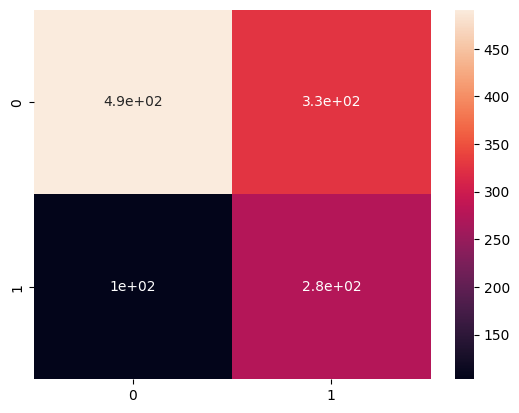

In [46]:
# get base scores
y_pred = model_tfd.predict(X_test)
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
print(classification_report(y_pred, y_test))
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)



# visualize performance
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_pred, y_test)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
plt.show()

# saving the performance in a dictionary
tfid_base_performance = {
    'accuracy':accuracy,
    'precision':precision,
    'recall':recall,
    'fscore': fscore,
    'cf_matrix': cf_matrix,
    'classification_report': classification_report}

In [47]:
# perform the grid search with the previous parameter grid
params = [param4, param7]
gs = GridSearchCV(pipeline, params, cv=3, 
                  n_jobs=-1).fit(X_train, y_train)

display(gs.score(X_train, y_train))
display(gs.score(X_test, y_test))

params = [param5, param3]
gs2 = GridSearchCV(pipeline, params, cv=3, 
                  n_jobs=-1).fit(X_train, y_train)

display(gs2.score(X_train, y_train))
display(gs2.score(X_test, y_test))

params = [param1, param6]
gs3 = GridSearchCV(pipeline, params, cv=3, 
                  n_jobs=-1).fit(X_train, y_train)

display(gs3.score(X_train, y_train))
display(gs3.score(X_test, y_test))

0.887038243230669

0.8284518828451883

0.6379454731552991

0.6410041841004184

0.7354610589001582

0.705439330543933

In [48]:
gs.best_params_

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=88, ...)}

## Performance Evaluation



In [49]:
## Performance Evaluation
y_pred = gs.predict(X_test)
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
print(classification_report(y_pred, y_test))
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.80      0.84      0.82       565
           1       0.85      0.81      0.83       630

    accuracy                           0.83      1195
   macro avg       0.83      0.83      0.83      1195
weighted avg       0.83      0.83      0.83      1195



In [72]:
params = [param7]
gs = GridSearchCV(pipeline, params, cv=3, 
                  n_jobs=-1).fit(X_train, y_train)
                  
                  
y_pred = gs.predict(X_test)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
cf_matrix = confusion_matrix(y_pred, y_test)
# saving the performance in a dictionary
tfdif_vectorizer_performance = {
    'accuracy':accuracy,
    'precision':precision,
    'recall':recall,
    'fscore': fscore,
    'cf_matrix': cf_matrix,
    'classification_report': classification_report}

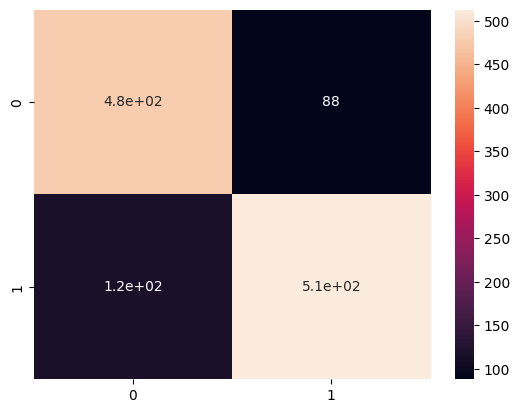

In [50]:
# visualize performance
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_pred, y_test)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
plt.show()

# saving the performance in a dictionary
tfdif_vectorizer_performance = {
    'accuracy':accuracy,
    'precision':precision,
    'recall':recall,
    'fscore': fscore,
    'cf_matrix': cf_matrix,
    'classification_report': classification_report}

In [75]:
tmp = pd.DataFrame([tfdif_vectorizer_performance, 
             tfid_base_performance,
             count_vectorizer_base_performance,
             count_vectorizer_performance])
results = tmp.drop(columns=['cf_matrix', 'classification_report'])
results

<Axes: >

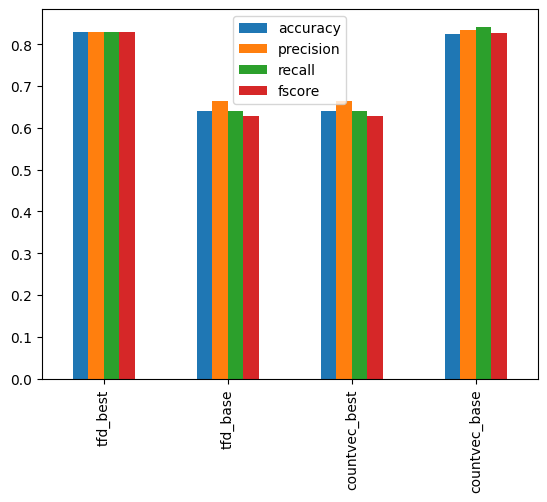

In [95]:
results.index = ['tfd_best', 'tfd_base', 'countvec_best', 'countvec_base']
results
results.plot(kind='bar')

**Note**: It would be interesting to evaluate how the models would perform over the full dataset, but from this, it shows that the XGBoost Classifier with default settings is performing at the same level or close to the complex Deep Learning algorithms. Note also that its performance is fairly consistent regardless of what text vectorizer was used. However, we cannot conclude that this would be the same for all the other classifiers.